# Plot Run Data
This notebook plots the performance of a run to assess the optimization performance and system utilization.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import json
import os

Load the run information 

In [2]:
run_info = pd.read_csv('run_data.csv')

Pick one

In [3]:
run_info = run_info.sort_values('start_time', ascending=False).iloc[0]
print(run_info)

path                runs/24Jun20-163856-34cf86
param_hash                              34cf86
start_time                 2020-06-24 16:38:05
parallel_guesses                            10
rl_episodes                                  4
search_size                                100
initial_count                               10
hostname                             thetamom1
worker_count                                 7
n_evals                                     45
Name: 0, dtype: object


## Load in Result File
This file is the list of the quantum chemistry results

In [4]:
result_data = pd.read_json(os.path.join(run_info['path'], 'simulation_records.jsonld'), lines=True)

Plot the time since first result

In [5]:
result_data['walltime'] = result_data['time_result_received'] - result_data['time_created'].min()

Plot the rate at which we aquired new results

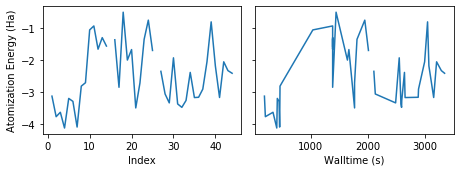

In [6]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(6.5, 2.5))

axs[0].plot(result_data.index, result_data['value'])
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Atomization Energy (Ha)')

axs[1].plot(result_data['walltime'], result_data['value'])
axs[1].set_xlabel('Walltime (s)')

fig.tight_layout()

## Evaluate Runtimes
Estimate the runtimes of the QC code

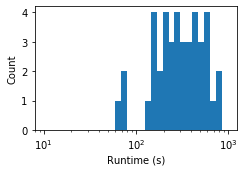

In [7]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.hist(result_data['time_running'], bins=np.logspace(1, 3, 32))
ax.set_xscale('log')

ax.set_xlabel('Runtime (s)')
ax.set_ylabel('Count')
fig.tight_layout()

## Plot the Number of Results Being Run at a Time
We can look at the runtime log to get when QC tasks are sent out and arrive

In [8]:
with open(os.path.join(run_info['path'], 'runtime.log')) as fp:
    log_data = pd.DataFrame(f.rstrip() for f in fp)
log_data.rename(columns={0: 'msg'}, inplace=True)
log_data['msg_num'] = log_data['msg'].str.match(r'^[\d]').cumsum()
log_data = log_data.groupby('msg_num').agg({'msg': lambda x: '\n'.join(x)})

In [9]:
log_data['time'], log_data['parsl'], log_data['level'], log_data['content'] = zip(*log_data['msg'].str.split(" - ", 3))

Compute the time since first message

In [10]:
log_data['time'] = pd.to_datetime(log_data['time'])

In [11]:
log_data['walltime'] = (log_data['time'] - log_data['time'].iloc[0]).apply(lambda x: x.total_seconds())

Find the events related to calculations starting and finishing

In [12]:
events = [{'time': 0, 'active_delta': 0}]
events.extend({'time': t, 'active_delta': -1} for t in 
          log_data[log_data['content'].str.match('^Client received a compute_atomization_energy')]['walltime'])
events.extend([{'time': t, 'active_delta': 1} for t in 
               log_data[log_data['content'].str.match('^Client sent a compute_atomization_energy')]['walltime']])
events = pd.DataFrame(events)

Make the results easier to plot

In [13]:
events.sort_values('time', ascending=True, inplace=True)

In [14]:
events['num_active'] = events['active_delta'].cumsum()

Compute worker utilization

In [15]:
events['queue_length'] = events['num_active']

In [16]:
events['utilization'] = np.clip(events['queue_length'] / run_info['worker_count'], 0, 1)

In [17]:
utilization_int = (np.diff(events['time'].values) * events['utilization'].values[:-1]).cumsum()

In [18]:
events['cumulative_utilization'] = None
events['cumulative_utilization'] = utilization_int / events['time'].iloc[1:]

Plot the queue length and utilization

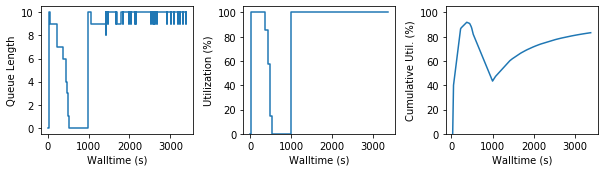

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(8.5, 2.5))

# Plot the queue length
ax = axs[0]
ax.step(events['time'], events['queue_length'], where='post')
ax.set_xlabel('Walltime (s)')
ax.set_ylabel('Queue Length')

ax = axs[1]
ax.step(events['time'], events['utilization'] * 100, where='post')
ax.set_xlabel('Walltime (s)')
ax.set_ylabel('Utilization (%)')
ax.set_ylim(0, 105)

ax = axs[2]
ax.plot(events['time'], events['cumulative_utilization'] * 100)
ax.set_xlabel('Walltime (s)')
ax.set_ylabel('Cumulative Util. (%)')
ax.set_ylim(0, 105)

fig.tight_layout()